In [1]:
from __future__ import division
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn.apionly as sns

from composition.analysis.load_sim import load_sim
from composition.support_functions.checkdir import checkdir
import composition.analysis.plotting_functions as plotting

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
def make_charge_energy_histogram(log_energy, charge, proton_mask, iron_mask, ax, plot_line=False):
    charge_bins = np.linspace(0, 6, 50)
    energy_bins = np.arange(6.2, 8.0, 0.05)
#     energy_bins = np.arange(6.2, 9.51, 0.05)
    energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    proton_hist, xedges, yedges = np.histogram2d(log_energy[MC_proton_mask],
                                                 charge[MC_proton_mask],
                                                 bins=[energy_bins,
                                                       charge_bins],
                                                 normed=False)
    proton_hist = np.ma.masked_where(proton_hist == 0, proton_hist)
    iron_hist, xedges, yedges = np.histogram2d(log_energy[MC_iron_mask],
                                               charge[MC_iron_mask],
                                               bins=[energy_bins, charge_bins],
                                               normed=False)

    h = proton_hist / (proton_hist + iron_hist)
    h = np.rot90(h)
    h = np.flipud(h)
    h = np.ma.masked_where(h == 0, h)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    def line_fit(array):
        fit = []
        for x in array:
            if x <= 9.0:
                slope = (5.3 - 2.55) / (9.5 - 6.2)
                fit.append(2.55 + slope * (x - 6.2))
            else:
                slope = (5.20 - 4.9) / (9.5 - 9.0)
                fit.append(4.9 + slope * (x - 9.0))
        fit = np.array(fit)
        return fit

    colormap = 'coolwarm'
    im = ax.imshow(h, extent=extent, origin='lower',
               interpolation='none', cmap=colormap,
               aspect='auto', vmin=0, vmax=1)
    x = np.arange(6.2, 9.51, 0.1)
    if plot_line:
        ax.plot(x, line_fit(x), marker='None', linestyle='--',
                 color='k')
    return im


number of events = 105912
number of events = 109203


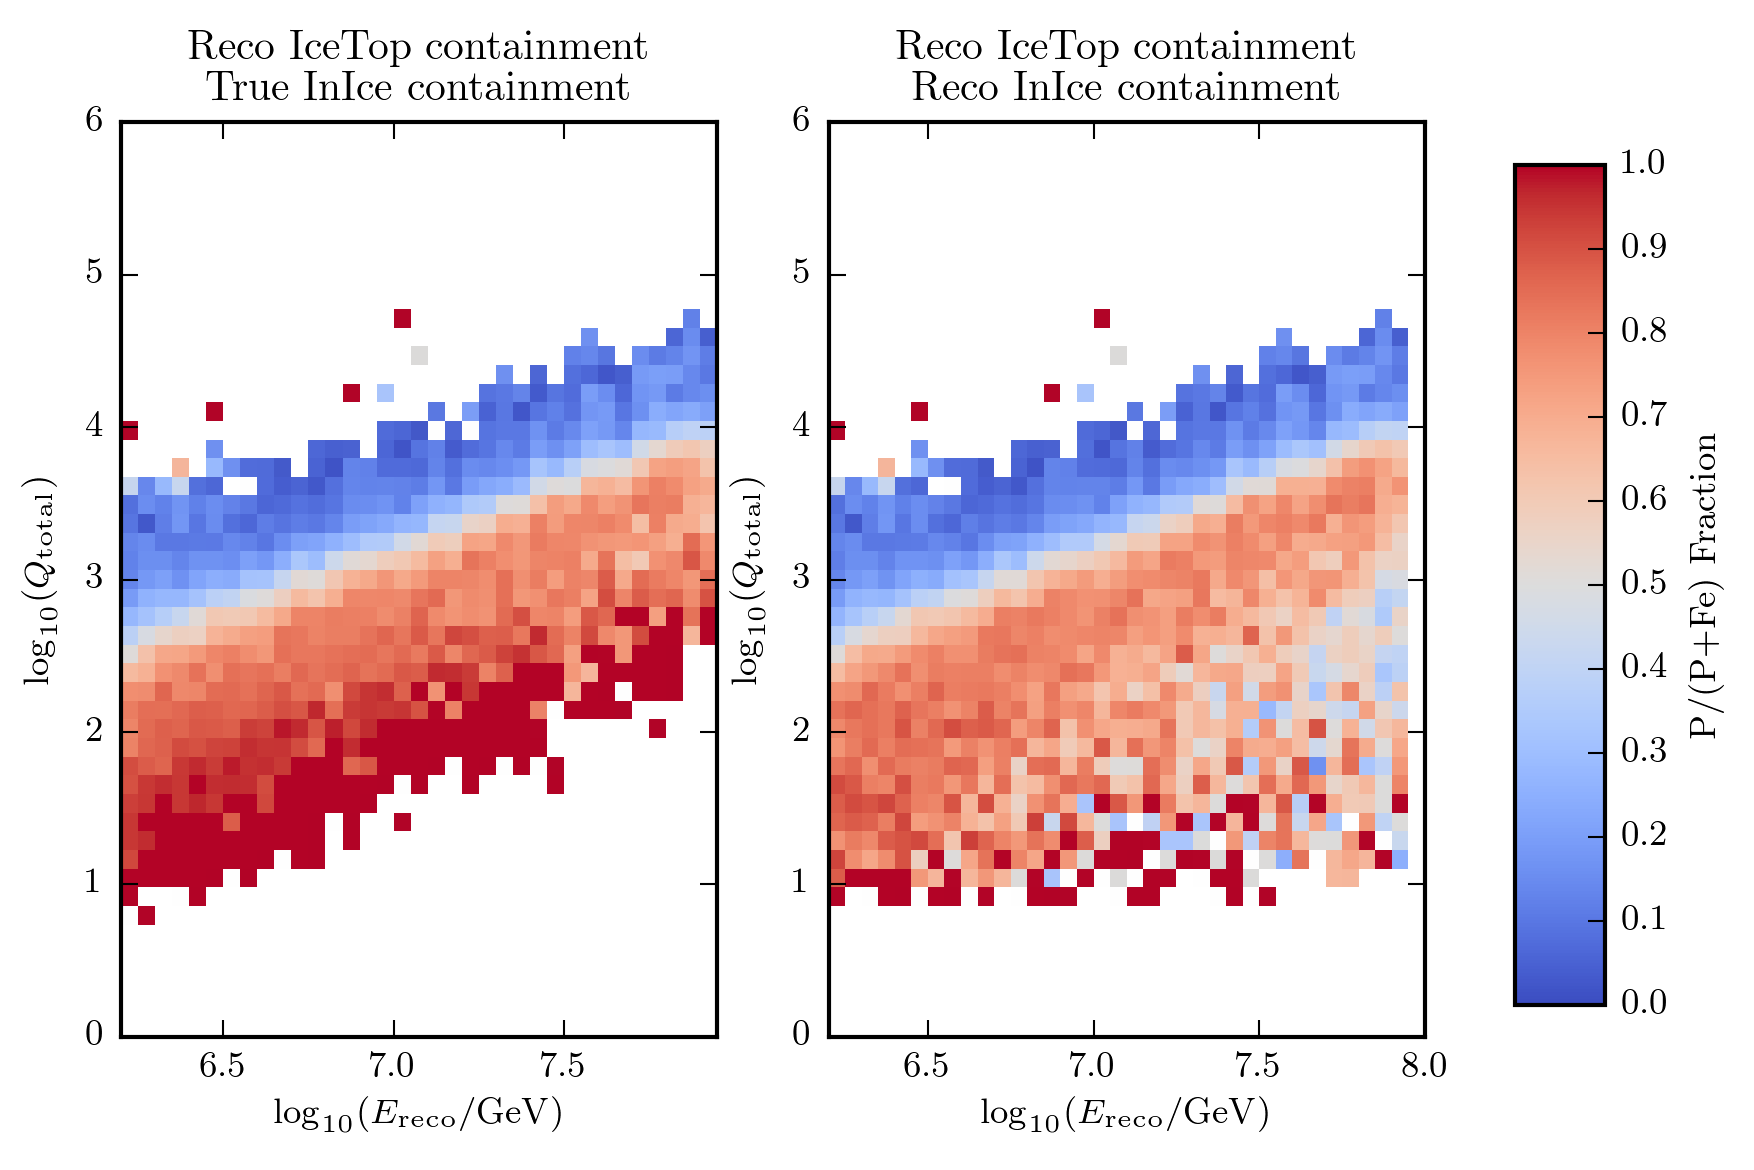

In [12]:
inice_containment = ['InIce_containment', 'reco_InIce_containment']
titles = ['Reco IceTop containment \n True InIce containment',
          'Reco IceTop containment \n Reco InIce containment']
fig, axarr = plt.subplots(1,2)
for containment, title, ax in zip(inice_containment, titles, axarr.flatten()):
    # Import ShowerLLH sim reconstructions and cuts to be made
    df, cut_dict = load_sim(return_cut_dict=True)
    selection_mask = np.array([True] * len(df))
#     standard_cut_keys = ['reco_exists', 'reco_zenith', 'min_hits', 'reco_IT_containment',
#                          'IceTopMaxSignalInEdge', 'IceTopMaxSignal', 'StationDensity',
#                          'min_energy', containment]
    standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                         'StationDensity', 'max_charge_frac', 'reco_IT_containment',
                         'min_energy', 'max_energy', containment]
    for key in standard_cut_keys:
        selection_mask *= cut_dict[key]

    df = df[selection_mask]
    print('number of events = {}'.format(len(df)))

    MC_proton_mask = (df.MC_comp == 'P')
    MC_iron_mask = (df.MC_comp == 'Fe')
    log_energy = df['reco_log_energy']
    charge = df.InIce_log_charge
    
    im = make_charge_energy_histogram(log_energy, charge, MC_proton_mask, MC_iron_mask, ax=ax)
    ax.set_title(title)
    plt.xlim([6.2, 8.0])
    plt.ylim([0, 6])
    ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
    ax.set_ylabel('$\log_{10}(Q_{\mathrm{total}})$')
    
# fig.text(0.5, 0.00, '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', ha='center')
# fig.text(0.00, 0.5, '$\log_{10}(Q_{\mathrm{total}})$', va='center', rotation='vertical')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='P/(P+Fe) Fraction')


number of events = 116310


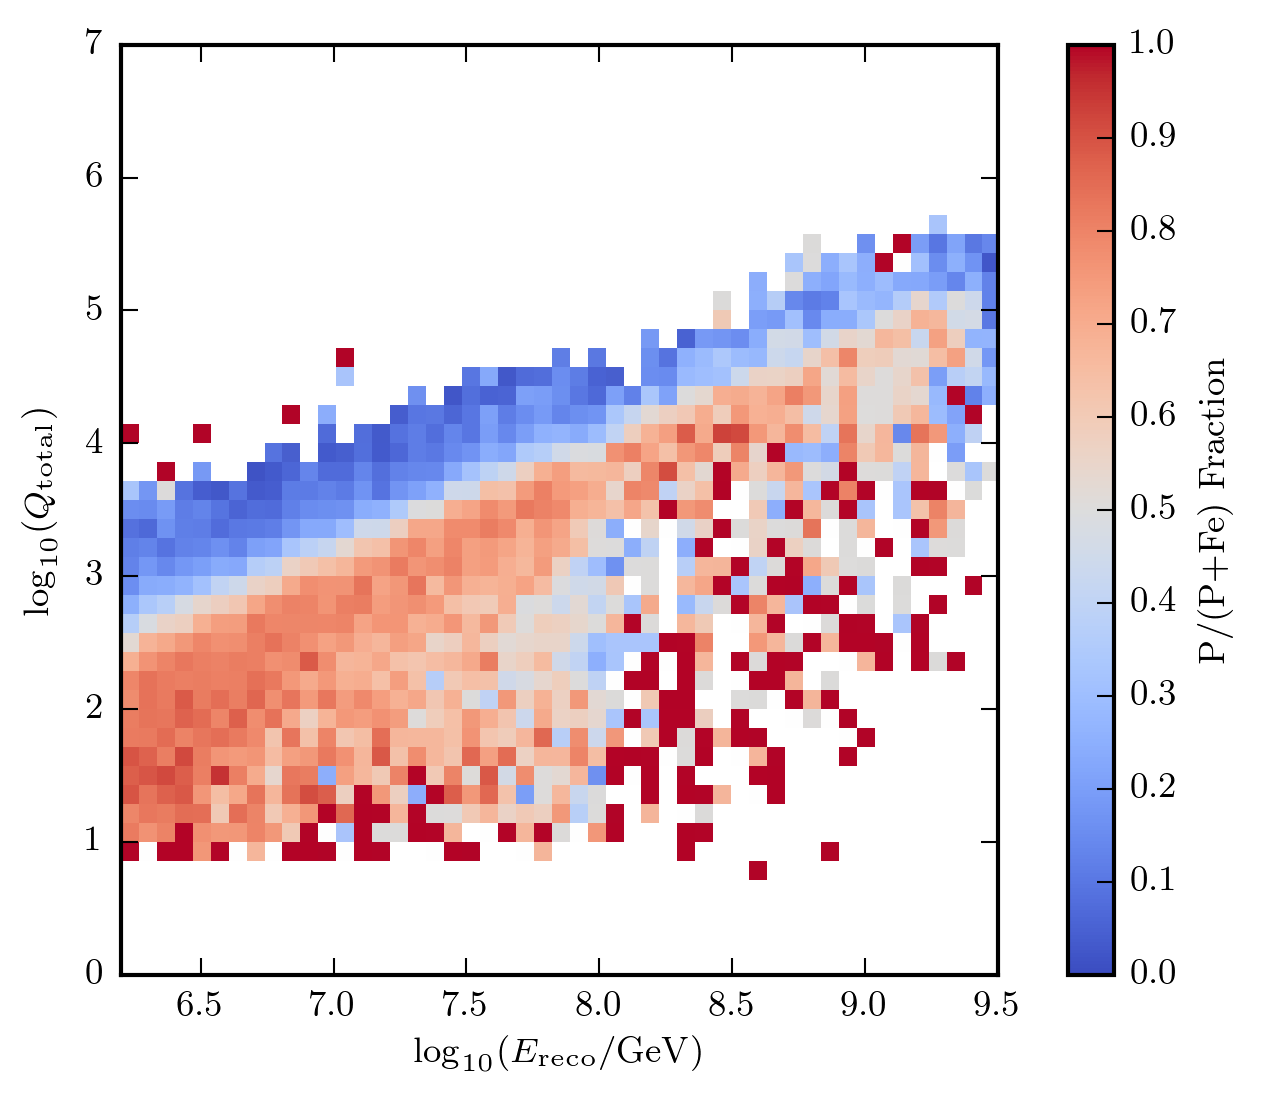

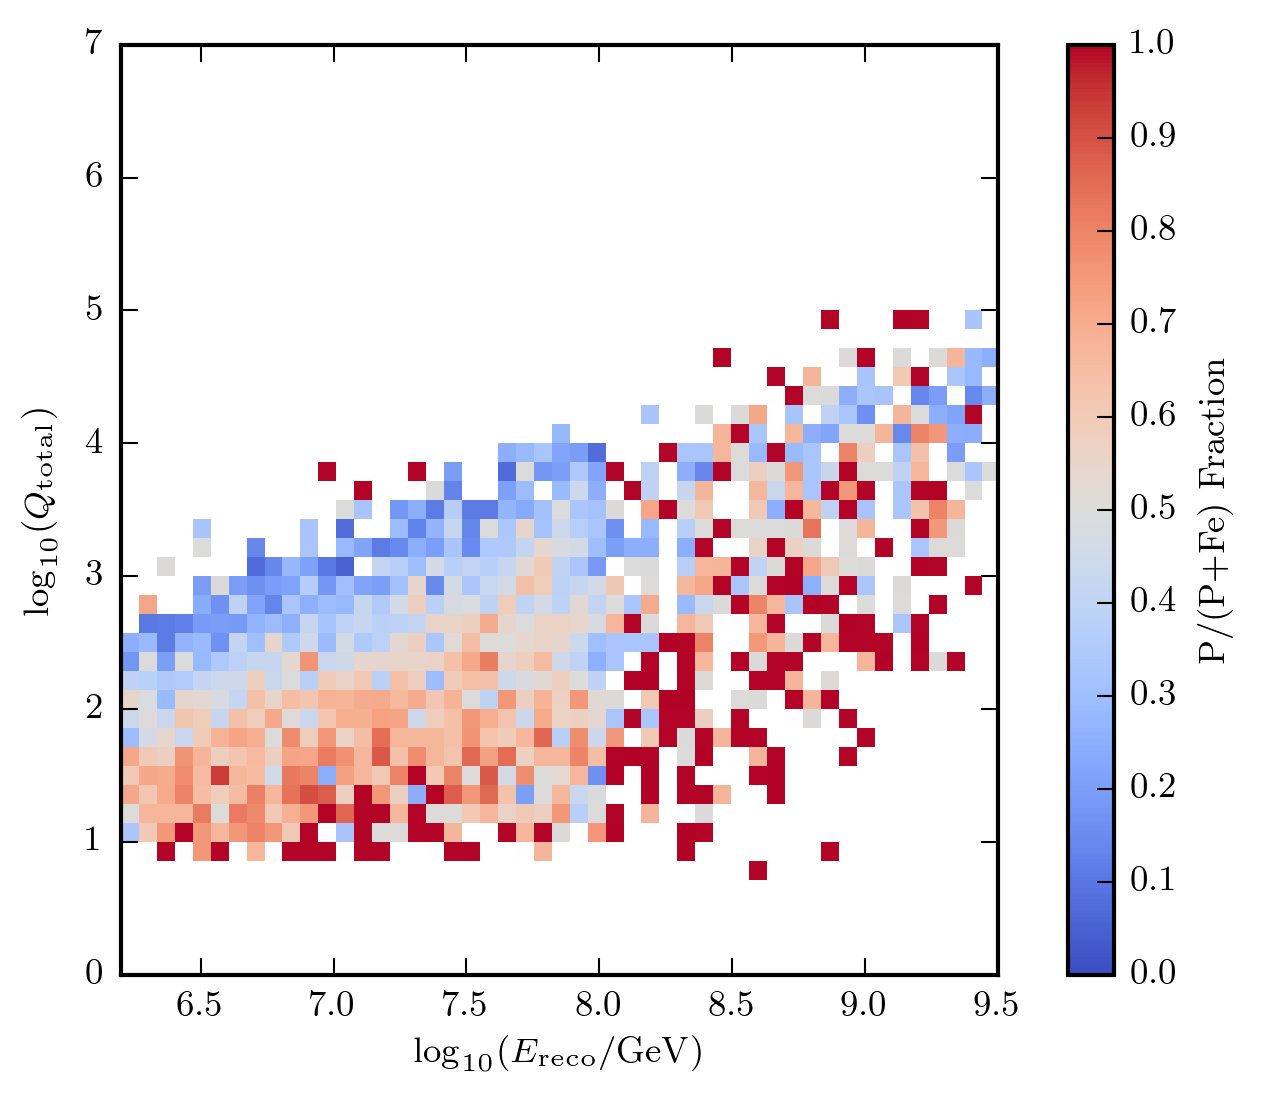

In [4]:
# Import ShowerLLH sim reconstructions and cuts to be made
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment',
                     'min_energy']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]
print('number of events = {}'.format(len(df)))

MC_proton_mask = (df.MC_comp == 'P')
MC_iron_mask = (df.MC_comp == 'Fe')
log_energy = df['reco_log_energy']
MC_log_energy = df['MC_log_energy']
charge = df.InIce_log_charge

fig, ax = plt.subplots()
im = make_charge_energy_histogram(log_energy, charge, MC_proton_mask, MC_iron_mask, ax=ax)
plt.xlim([6.2, 9.5])
plt.ylim([0, 7])
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
plt.ylabel('$\log_{10}(Q_{\mathrm{total}})$')
cb = fig.colorbar(im, label='P/(P+Fe) Fraction')
plt.show()

MC_InIce_containment = df.InIce_FractionContainment
containment_bins = np.linspace(0, 2, 100)
fig, ax = plt.subplots()
im = make_charge_energy_histogram(log_energy[MC_InIce_containment >= 1.0],
                                  charge[MC_InIce_containment >= 1.0],
                                  MC_proton_mask[MC_InIce_containment >= 1.0],
                                  MC_iron_mask[MC_InIce_containment >= 1.0], ax=ax)
plt.xlim([6.2, 9.5])
plt.ylim([0, 7])
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
plt.ylabel('$\log_{10}(Q_{\mathrm{total}})$')
cb = fig.colorbar(im, label='P/(P+Fe) Fraction')
plt.show()

# fig, ax = plt.subplots()
# energy_bins = np.arange(6.2, 9.51, 0.05)
# # energy_bins = np.linspace(6.2, 9.51, 50)
# im = plotting.histogram_2D(MC_log_energy, log_energy, energy_bins, log_counts=True, make_prob=True, ax=ax)
# # ax.set_title(title)
# # plt.xlim([6.2, 9.5])
# plt.show()



number of events = 116310
(11560,)
(116310,)
0.0993895623764


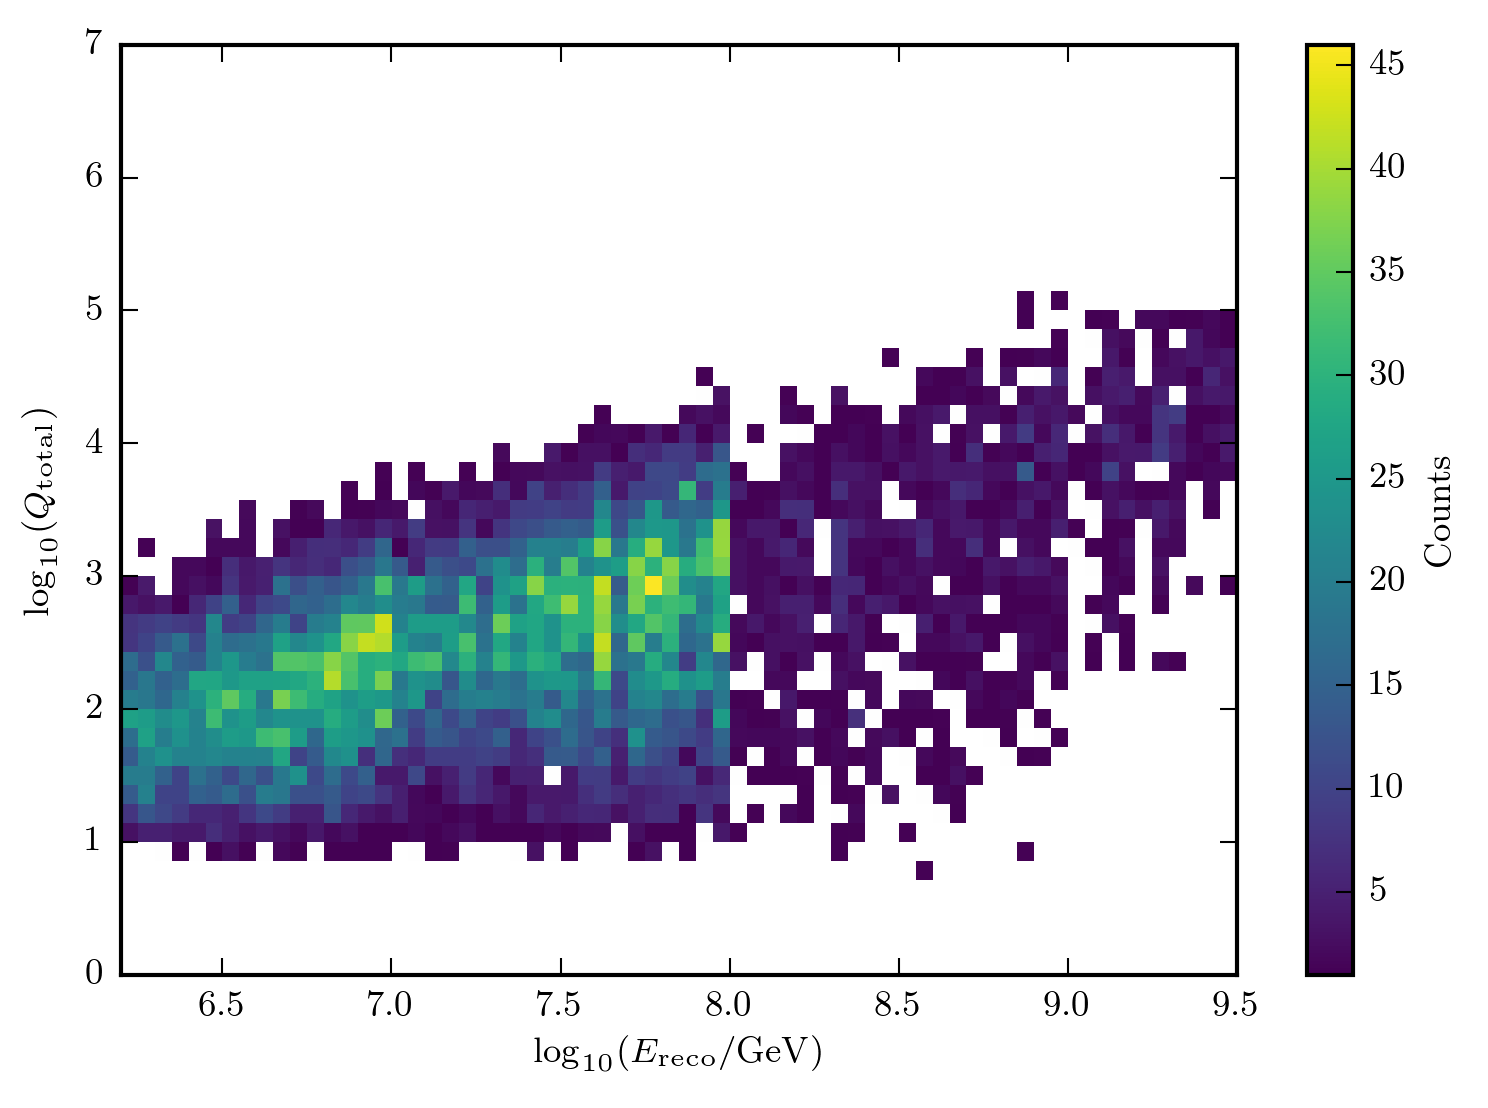

In [32]:
# Import ShowerLLH sim reconstructions and cuts to be made
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment',
                     'min_energy']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]
print('number of events = {}'.format(len(df)))

# MC_proton_mask = (df.MC_comp == 'P')
# MC_iron_mask = (df.MC_comp == 'Fe')
log_energy = df['reco_log_energy']
MC_log_energy = df['MC_log_energy']
charge = df.InIce_log_charge

charge_bins = np.linspace(0, 7, 50)
energy_bins = np.arange(6.2, 9.51, 0.05)
bins = [energy_bins, charge_bins]

MC_InIce_containment = df.InIce_FractionContainment
containment_mask = (MC_InIce_containment > 1.0)
print(charge[containment_mask].shape)
print(charge.shape)
print(len(charge[containment_mask])/len(charge))
fig, ax = plt.subplots()
im = plotting.histogram_2D(log_energy[containment_mask],
                           charge[containment_mask],
                           bins=bins, log_counts=False)
# bins=[charge_bins, energy_bins])
plt.xlim([6.2, 9.5])
plt.ylim([0, 7])
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
plt.ylabel('$\log_{10}(Q_{\mathrm{total}})$')
plt.show()

In [7]:
MC_InIce_containment = df.InIce_FractionContainment
ShowerLLH_InIce_containment = df.reco_InIce_containment

number of events = 116310


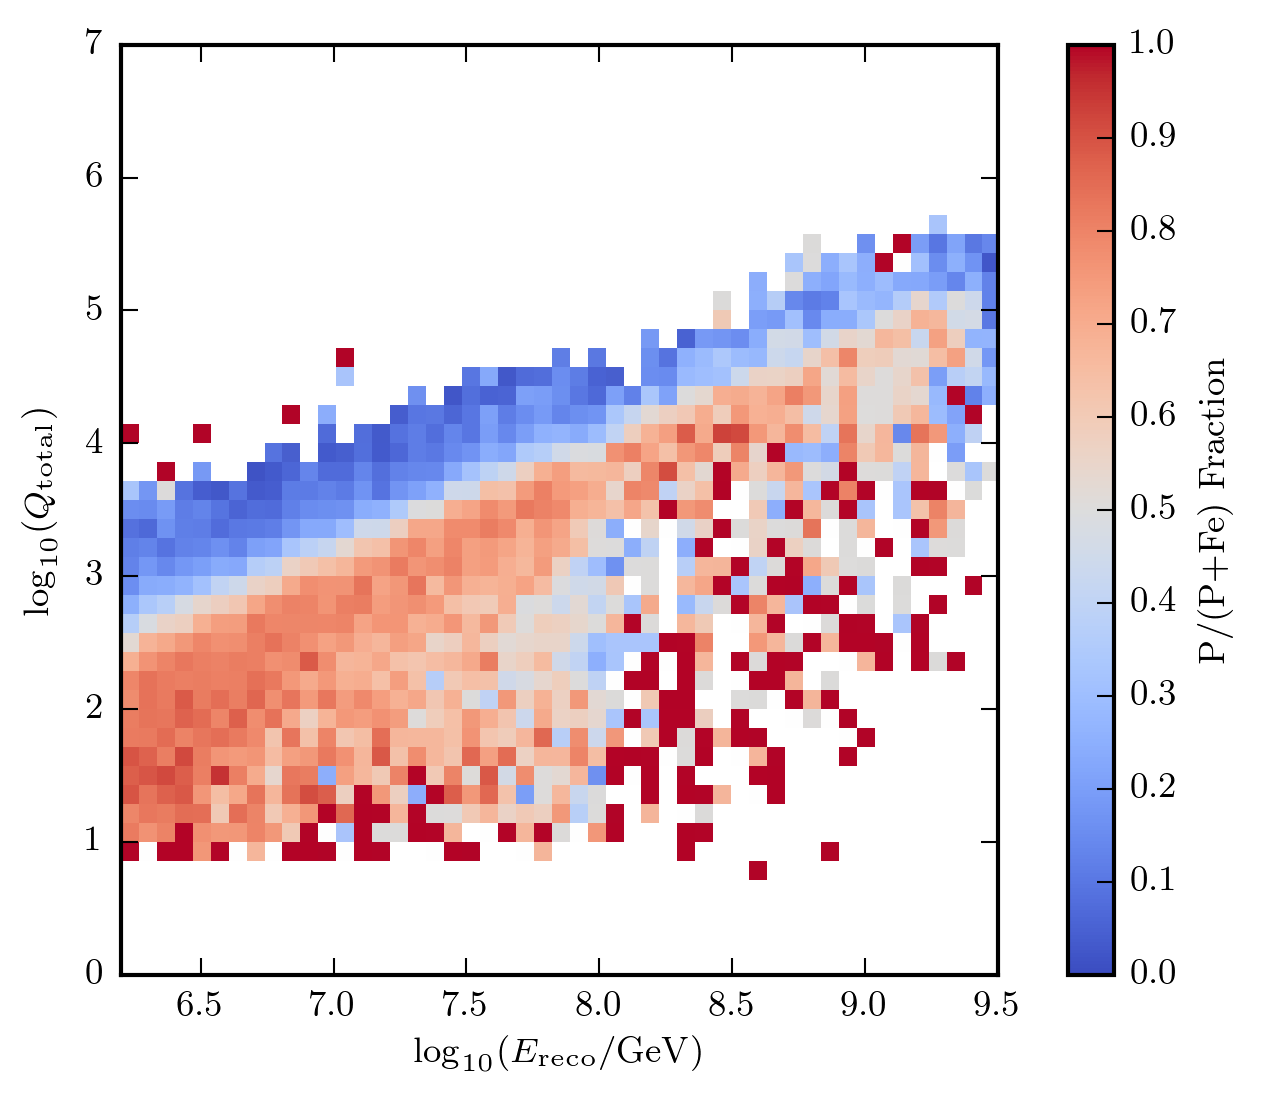

In [12]:
# Import ShowerLLH sim reconstructions and cuts to be made
df, cut_dict = load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits', 'IT_signal',
                     'StationDensity', 'max_charge_frac', 'reco_containment',
                     'min_energy']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]
print('number of events = {}'.format(len(df)))

MC_proton_mask = (df.MC_comp == 'P')
MC_iron_mask = (df.MC_comp == 'Fe')
log_energy = df['reco_log_energy']
charge = df.InIce_log_charge

fig, ax = plt.subplots()
im = make_charge_energy_histogram(log_energy, charge, MC_proton_mask, MC_iron_mask, ax=ax)
plt.xlim([6.2, 9.5])
plt.ylim([0, 7])
ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(Q_{\mathrm{total}})$')

# fig.text(0.5, 0.00, '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', ha='center')
# fig.text(0.00, 0.5, '$\log_{10}(Q_{\mathrm{total}})$', va='center', rotation='vertical')
# plt.tight_layout()
# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax, label='P/(P+Fe) Fraction')
plt.colorbar(im, label='P/(P+Fe) Fraction')
